# 1. Importing libraries

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import os
import cv2

In [2]:
tf.random.set_seed(0) # setting a seed ensures our model is reproductible for the same data

# 2. Creating the dataset
Dataset Download URL: https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset

*put all the images of the trainig and testing datasets together in a single folder for each, named "covid", "viral_pneumonia" and "normal". This will fix some of the dataset errors and will facilitate the work.

We are going to use de OpenCV library the help us in that task.

The dataset we have consists of X-ray images of 3 categories of data:
- 'normal'
- 'covid'
- 'viral_pneumonia'

The images are divided in 3 folders, in which we are going to iterate to read the data and append it to a dataset.

The images are made of individual pixels with 3 values (channels) each, that can have a range of values between 0 and 255.

In [3]:
categories = ['covid','normal','viral_pneumonia'] # naming the categories
img_size = 128 # the image size we will use in our model
img_data = [] # initializing the variable tha we will append the data

def create_dataset(): # this function will create the dataset
    for category in categories: # iterarion through each category name we defined
        path = os.path.join('data', category) # the path of each categorie folder
        class_num = categories.index(category) # the index of te category (0,1,2) for each category.
        for img in os.listdir(path): # iterating each image in the folder
            img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE) # reading the image into a numpy ndarray, also turning it to grayscale to simplify the model
            new_array = cv2.resize(img_array, (img_size,img_size)) # resizing
            img_data.append([new_array,class_num]) # appending to our dataset variable
create_dataset()

# 3. Data Preprocessing
Our dataset is in the appending order, and that can lead to problems in training. To fix that, we just need to shuffle the data in a random manner.

In [4]:
import random
random.shuffle(img_data)

## 3.1 Splitting our data into features and labels

In [5]:
X = [] # features
y = [] # labels

In [6]:
for features, label in img_data:
    X.append(features)
    y.append(label)
    
X = np.array(X).reshape(-1,img_size,img_size,1)/255 #reshaping and normalizing our data

In [7]:
y = np.array(y)

In [8]:
print(f'''
X shape: {X.shape}
y shape:{y.shape}
''')


X shape: (312, 128, 128, 1)
y shape"(312,)



## 3.2 Splitting into training, test and validation

In [9]:
from sklearn.model_selection import train_test_split as tts

X_train0, X_test, y_train0, y_test = tts(X,y,test_size=0.20, random_state=0)
X_train, X_val, y_train, y_val = tts(X,y,test_size=0.1, random_state=0)

In [10]:
X_train.shape

(280, 128, 128, 1)

# 4. Model Building and Training
We are going to use a MLP (multilayer perceptron) to train our data.

We are also going to use a hyperparameter tuning technique using the Keras Tuner library. This is going to help us find better hyperparameters for our model with less work overall.

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from keras_tuner.tuners import BayesianOptimization
from keras_tuner.engine.hyperparameters import HyperParameters

## 4.1 Creating our model using Keras Tuner
This is very similar to a conventional model building.

Step 1 - Build a function with you model inside it.

Step 2 - Use the hp argument along with your desired hyperparameter space to define the hyperparameters during the model creation.

Step 3 - Initialize the tuner specifying the objective to select the best model, along with "max_trial" to set the number of different models to try.

Step 4 - Start the search and get the best model as an object.

*in this example we are going to use the BayesianOptimization tuner

In [12]:
# step 1
def build_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=X.shape[1:]))
    
    # step 2
    hp_activation = hp.Choice(name = 'activation', values = ['relu', 'tanh'])
    hp_layer_1 = hp.Int(name = "layer_1", min_value = 16, max_value = 128, step = 16) # here you set the minimum and maximum value of neurons in this layer, along with the step per iteration in the tuner.
    hp_layer_2 = hp.Int(name = "layer_2", min_value = 16, max_value = 128, step = 16)
    hp_layer_3 = hp.Int(name = "layer_3", min_value = 16, max_value = 128, step = 16)
    hp_dropout_1 = hp.Choice(name = "dropout_1", values = [0.0, 0.1, 0.2, 0.3]) # here the tuner will choose between a set o given values
    hp_dropout_2 = hp.Choice(name = "dropout_2", values = [0.0, 0.1, 0.2, 0.3])
    hp_learning_rate = hp.Choice(name = "learning_rate", values = [1e-2, 1e-3, 1e-4]) # same thing for the learning rates
    
    #use the arguments above in the layers below
    
    model.add(Dense(hp_layer_1, activation = hp_activation))
    model.add(Dropout(rate=hp_dropout_1))
    model.add(Dense(hp_layer_2, activation = hp_activation))
    model.add(Dropout(rate=hp_dropout_2))
    model.add(Dense(hp_layer_3, activation = hp_activation))
    model.add(Dropout(rate=hp_dropout_2))
    
    model.add(Dense(3, activation = "softmax"))
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer= tf.keras.optimizers.Adam(learning_rate = hp_learning_rate),
                  metrics=['accuracy'])
    return model

# step 3
tuner = BayesianOptimization(build_model,
                    objective = "val_accuracy",
                    max_trials = 16,
                    overwrite=True
                    )

# step 4
tuner.search(x = X_train,
             y = y_train,
             epochs = 64,
             batch_size = 8,
             validation_data = (X_val, y_val))

Trial 16 Complete [00h 00m 19s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 06m 18s
INFO:tensorflow:Oracle triggered exit


# 5. Final Model Training and Results
To see the results, we use the tuner.get_best_hyperparameters and save it to a variable.

Then we build our model using these best hyperparameters that we found and fit to the test data.

In [13]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=128, validation_data = (X_test,y_test), verbose=0)
score = model.evaluate(X_test, y_test, verbose=0)

In [14]:
print(f"Test loss: {score[0]}")
print(f"Test accuracy: {score[1]}")

Test loss: 0.017198028042912483
Test accuracy: 1.0


In [15]:
y_prob = model.predict(X_test)
y_pred = np.argmax(y_prob, axis=-1)

2/2 [==============================] - 0s 6ms/step


<AxesSubplot:>

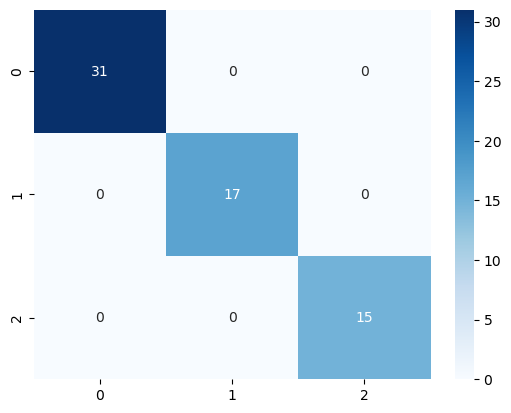

In [18]:
from sklearn.metrics import confusion_matrix as cm
matrix = sns.heatmap(cm(y_test, y_pred), cmap='Blues', annot=True)
matrix

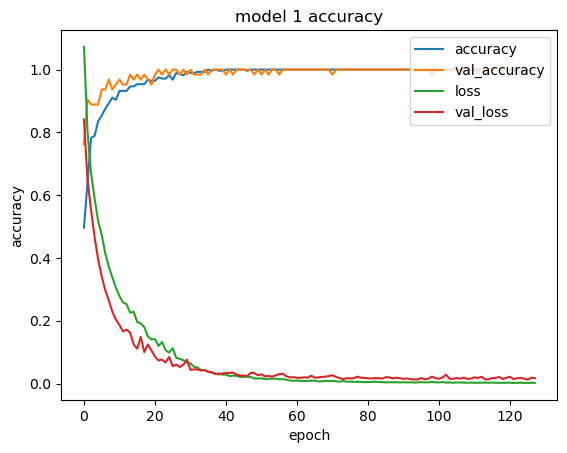

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model 1 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy','loss','val_loss'], loc='upper right')
plt.show()

We can see that our model coverged really fast, probably due to the small batch size.

# 6. Saving the Trained Model
To save it, we will just serialize to a pickle object and put it in our notebook directory.

In [21]:
import pickle
model_dump = pickle.dump(model, open(os.path.join('trained_mlp_model.pkl'), 'wb'))

INFO:tensorflow:Assets written to: ram://d6d60db7-a730-4428-acb4-b977df8a6db5/assets
